In [34]:
# This is hardly inspired by the work of Raven Ron on https://www.kaggle.com/codeastar/random-forest-classification-on-talkingdata

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
import pickle
import itertools
%matplotlib inline

import os
# print(os.listdir("../input"))

import gc, time

dtypes = {
    'ip'            : 'uint32',
    'app'           : 'uint16',
    'device'        : 'uint16',
    'os'            : 'uint16',
    'channel'       : 'uint16',
    'is_attributed' : 'uint8',
    'click_id'      : 'uint32'
}


path = '~/Kaggle/dados_kaggle/'

def handleClickHour(df):
    df['click_hour']= (pd.to_datetime(df['click_time']).dt.round('H')).dt.hour
    df['click_hour'] = df['click_hour'].astype('uint16')
    df = df.drop(['click_time'], axis=1)   
    return df

train_columns = ['ip', 'app', 'device', 'os', 'channel', 'hours', 'minutes', 'seconds', 'is_attributed']

In [46]:
# Importing data

start_time = time.time()
df_train_30m = pd.read_csv(path + '10_train_timed.csv', dtype=dtypes, usecols=train_columns)
print('Load df_train_30m with {} seconds'.format(round(time.time() - start_time, 3)))

Load df_train_30m with 18.258 seconds


In [47]:
# Load testing df
start_time = time.time()
df_test = pd.read_csv(path + 'test_timed.csv', dtype=dtypes)
print('Load df_test with {} seconds'.format(round(time.time() - start_time, 3)))

train_record_index = df_train_30m.shape[0]

Load df_test with 18.753 seconds


In [48]:
df_train_30m.head()

,ip,app,device,os,channel,is_attributed,hours,minutes,seconds
0,103022,3,1,23,379,0,14,37,44
1,114221,3,1,19,379,0,14,37,59
2,47902,3,1,17,379,0,14,48,7
3,23550,3,1,13,379,0,14,53,39
4,84644,3,1,19,379,0,14,56,49


In [49]:
df_test.head()

,click_id,ip,app,device,os,channel,days,hours,minutes,seconds
0,0,5744,9,1,3,107,10,4,0,0
1,1,119901,9,1,3,466,10,4,0,0
2,2,72287,21,1,19,128,10,4,0,0
3,3,78477,15,1,13,111,10,4,0,0
4,4,123080,12,1,13,328,10,4,0,0


In [50]:
#df for submit
df_submit = pd.DataFrame()
df_submit['click_id'] = df_test['click_id']

#Extracting learning data
Learning_Y = df_train_30m['is_attributed']
print('Training target correctly extracted.')

#drop zone
df_test = df_test.drop(['click_id', 'days'], axis=1)
df_train_30m = df_train_30m.drop(['is_attributed'], axis=1)
gc.collect();

df_merge = pd.concat([df_train_30m, df_test])
del df_train_30m, df_test
gc.collect();
print('Data was correctly merged')

Training target correctly extracted.
Data was correctly merged


In [51]:
# Count all features except device for both train and test df 
start_time = time.time()
columns = df_merge.columns
columns = [i for i in columns if i != 'app' and i != 'device' and i != 'os' and
           i != 'channel' and i != 'days' and i != 'hours' and i != 'minutes' and i != 'seconds']

for col in columns:
    df_count = df_merge[col].value_counts().reset_index(name=col+'_count')
    df_count.columns = [col, col+'_count']
#print('Starting to merge with main dataset...')
    df_merge = df_merge.merge(df_count, on=col, how='left', sort=False)
    df_merge[col+'_count'] = df_merge[col+'_count'].astype('uint16')
#print('Merging operation completed.')
    del df_count
    
print('Loaded counts for all features with {} seconds'.format(round(time.time() - start_time, 3)))

Loaded counts for all features with 21.108 seconds


In [52]:
gc.collect();

df_train = df_merge[:train_record_index]
df_test = df_merge[train_record_index:]

del df_merge
gc.collect();

In [53]:
df_train.head()

,ip,app,device,os,channel,hours,minutes,seconds,ip_count
0,103022,3,1,23,379,14,37,44,1042
1,114221,3,1,19,379,14,37,59,603
2,47902,3,1,17,379,14,48,7,1051
3,23550,3,1,13,379,14,53,39,700
4,84644,3,1,19,379,14,56,49,14689


# Machine Learning

In [10]:
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Separating training data in train and cross-validation
train_idx, test_idx = model_selection.StratifiedKFold(n_splits=2).split(df_train, Learning_Y)

X_train = df_train.iloc[train_idx[:1]]
Y_train = Learning_Y.iloc[train_idx[:1]]

X_cv = df_train.iloc[test_idx[:1]]
Y_cv = Learning_Y.iloc[test_idx[:1]]

## 1. Baseline

In [53]:
# Selecting the features
param = X_train.columns
param = [i for i in param if i != 'ip' and i != 'app_count' and i != 'os_count' and i != 'channel_count']
X = X_train[param]
XX_cv = X_cv[param]

In [54]:
# Start of Random Forest Implementation
from sklearn.ensemble import RandomForestClassifier

print('Starting to fit Random Forest Model... The machine is learning...')
start_time = time.time()
rf = RandomForestClassifier(n_estimators=13, max_depth=13, verbose=0, n_jobs = -1)
rf = rf.fit(X, Y_train)
print('The machine has learned.')
print('RandomForest has fitted df_train_30m with {} seconds'.format(round(time.time() - start_time), 3))

Starting to fit Random Forest Model... The machine is learning...
The machine heas learned.
RandomForest has fitted df_train_30m with 197 seconds


### 1.1. Evaluating

In [15]:
from matplotlib.font_manager import FontProperties
import seaborn as sns
import pickle
import itertools
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def clf_eval(clf, X, y_true, classes=['Não baixou', 'Baixou'], normalize=False):
    y_pred = clf.predict(X)
    clf_matrix = confusion_matrix(y_true, y_pred)
    print('Classification Report')
    print(classification_report(y_true, y_pred, target_names=classes))
    print('ROC Score: {}'.format(roc_auc_score(y_true, y_pred)))
    print('Accuracy Score: {}'.format(accuracy_score(y_true, y_pred)))
    print('Average Precision Score: {}'.format(average_precision_score(y_true, y_pred)))
    print('f1 Score: {}'.format(f1_score(y_true, y_pred)))
    plot_confusion_matrix(clf_matrix, classes=classes, normalize=normalize)
    
    return roc_auc_score(y_true, y_pred)

Classification Report
             precision    recall  f1-score   support

 Não baixou       1.00      1.00      1.00   9222278
     Baixou       0.78      0.44      0.56     22916

avg / total       1.00      1.00      1.00   9245194

ROC Score: 0.7176886677284131
Accuracy Score: 0.9983011713978095
Average Precision Score: 0.3423464558521833
f1 Score: 0.5597353815103436
Normalized confusion matrix
[[9.99699207e-01 3.00793361e-04]
 [5.64321871e-01 4.35678129e-01]]


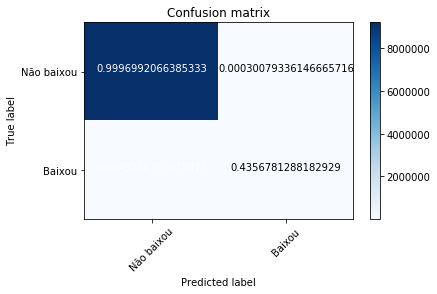

In [56]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

roc_bl = clf_eval(rf, XX_cv, Y_cv, normalize=True)

## 2. Just counts

Primeira tentaiva de melhora será dropar as colunas com os dados em si e usar apenas a contagem

In [57]:
# Selecting the features
param = X_train.columns
param = [i for i in param if i != 'ip' and i != 'app' and i != 'os' and i != 'channel' and i != 'device']
X = X_train[param]
XX_cv = X_cv[param]

In [58]:
# Start of Random Forest Implementation

print('Starting to fit Random Forest Model... The machine is learning...')
start_time = time.time()
rf = RandomForestClassifier(n_estimators=13, max_depth=13, verbose=0, n_jobs = -1)
rf = rf.fit(X, Y_train)
print('The machine has learned.')
print('RandomForest has fitted df_train_30m with {} seconds'.format(round(time.time() - start_time), 3))

Starting to fit Random Forest Model... The machine is learning...
The machine has learned.
RandomForest has fitted df_train_30m with 214 seconds


### 2.1 Evaluating 

Classification Report
             precision    recall  f1-score   support

 Não baixou       1.00      1.00      1.00   9222278
     Baixou       0.79      0.39      0.52     22916

avg / total       1.00      1.00      1.00   9245194

ROC Score: 0.6930793502065126
Accuracy Score: 0.9982271870119762
Average Precision Score: 0.30746434784684784
f1 Score: 0.5193548387096774
Normalized confusion matrix
[[9.99747459e-01 2.52540641e-04]
 [6.13588759e-01 3.86411241e-01]]


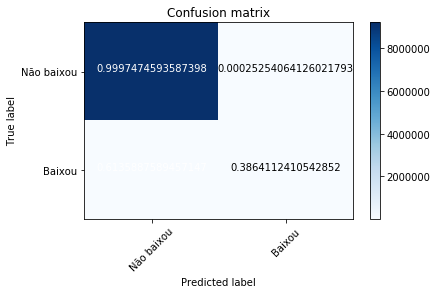

In [59]:
roc_counts = clf_eval(rf, XX_cv, Y_cv, normalize=True)

## 3. Undersampling

In [11]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X_resampled, Y_resampled, idx_resampled = rus.fit_sample(df_train, Learning_Y)

X_resampled = pd.DataFrame(X_resampled, columns=df_train.columns)
Y_resampled = pd.DataFrame(Y_resampled, columns=['is_attributed'])

train_idx, test_idx = model_selection.StratifiedKFold(n_splits=2).split(X_resampled, Y_resampled)

X_train = X_resampled.iloc[train_idx[:1]]
Y_train = Y_resampled.iloc[train_idx[:1]]

X_cv = X_resampled.iloc[test_idx[:1]]
Y_cv = Y_resampled.iloc[test_idx[:1]]

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45832 entries, 22916 to 91663
Data columns (total 11 columns):
ip               45832 non-null int64
app              45832 non-null int64
device           45832 non-null int64
os               45832 non-null int64
channel          45832 non-null int64
hours            45832 non-null int64
seconds          45832 non-null int64
ip_count         45832 non-null int64
app_count        45832 non-null int64
os_count         45832 non-null int64
channel_count    45832 non-null int64
dtypes: int64(11)
memory usage: 4.2 MB


Note que mesmo após o undersampling ficamos com uma boa quantidade de dados, graças ao tamanho da base de dados original. Após feito o undersampling, vamos tentar várias features diferentes

### 3.1 Fitting (baseline)

In [13]:
# Selecting the features (baseline)
from sklearn.ensemble import RandomForestClassifier

param = X_train.columns
param = [i for i in param if i != 'ip' and i != 'app_count' and i != 'os_count' and i != 'channel_count']
X = X_train[param]
XX_cv = X_cv[param]

# Start of Random Forest Implementation

print('Starting to fit Random Forest Model... The machine is learning...')
start_time = time.time()
rf = RandomForestClassifier(n_estimators=13, max_depth=13, verbose=0, n_jobs = -1)
rf = rf.fit(X, Y_train['is_attributed'])
print('The machine has learned.')
print('RandomForest has fitted df_train_30m with {} seconds'.format(round(time.time() - start_time), 3))

Starting to fit Random Forest Model... The machine is learning...
The machine has learned.
RandomForest has fitted df_train_30m with 0 seconds


#### 3.1 Evaluating (baseline)

Classification Report
             precision    recall  f1-score   support

 Não baixou       0.88      0.97      0.92     22916
     Baixou       0.97      0.87      0.92     22916

avg / total       0.92      0.92      0.92     45832

ROC Score: 0.9196412986559609
Accuracy Score: 0.9196412986559609
Average Precision Score: 0.9052339730665426
f1 Score: 0.9154635389170702
Normalized confusion matrix
[[0.96906092 0.03093908]
 [0.12977832 0.87022168]]


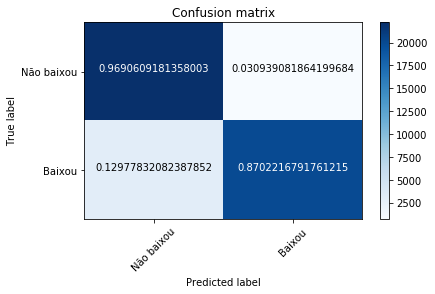

In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

roc_usample_bl = clf_eval(rf, XX_cv, Y_cv, normalize=True)

### 3.2 Fitting (counts)

In [158]:
# Selecting the features
param = X_train.columns
param = [i for i in param if i != 'ip' and i != 'app' and i != 'os' and i != 'channel' and i != 'device']
X = X_train[param]
XX_cv = X_cv[param]

# Start of Random Forest Implementation

print('Starting to fit Random Forest Model... The machine is learning...')
start_time = time.time()
rf = RandomForestClassifier(n_estimators=13, max_depth=13, verbose=0, n_jobs = -1)
rf = rf.fit(X, Y_train['is_attributed'])
print('The machine has learned.')
print('RandomForest has fitted df_train_30m with {} seconds'.format(round(time.time() - start_time), 3))

Starting to fit Random Forest Model... The machine is learning...
The machine has learned.
RandomForest has fitted df_train_30m with 0 seconds


#### 3.2.1 Evaluating (counts)

Classification Report
             precision    recall  f1-score   support

 Não baixou       0.89      0.96      0.92     22916
     Baixou       0.96      0.88      0.92     22916

avg / total       0.92      0.92      0.92     45832

ROC Score: 0.9202085878861931
Accuracy Score: 0.9202085878861931
Average Precision Score: 0.9033512778988774
f1 Score: 0.9166115608254475
Normalized confusion matrix
[[0.96334439 0.03665561]
 [0.12292721 0.87707279]]


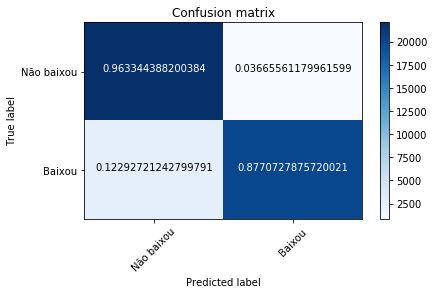

In [159]:
roc_usample_counts = clf_eval(rf, XX_cv, Y_cv, normalize=True)

## 3.3 Try adding information about time

In [33]:
start_time = time.time()

df_merge = pd.concat([df_train, df_test])
# del df_train, df_test
ips = X_resampled.ip.unique()
dic = []

for ip in ips:
    temp = df_merge[df_merge.ip == ip]
    temp.seconds = temp.hours*3600 + temp.seconds
    temp.seconds = temp.minutes*60 + temp.seconds
    temp = temp.drop(['hours', 'minutes'], axis=1)
    average = abs(temp.seconds - temp.seconds.shift(-1)).mean()
    dic.append([ip, average])
    #if temp.seconds.value_counts().iloc[0] == 1:
    #    dic.append([ip, 0])
    #else:
    #    average = abs(temp.seconds - temp.seconds.shift(-1))
    #    average = average.mean()
    #    dic.append([ip, average])
    del temp
    
print('Finish creating new feature in {} seconds'.format(round(time.time() - start_time), 3))

Finish creating new feature in 1608 seconds


In [55]:
dic = pd.DataFrame(dic, columns=['ip', 'delta_seconds'])
X_resampled = X_resampled.merge(dic, on='ip', how='left')
X_resampled.head()

In [58]:
# Selecting the features
param = X_resampled.columns
param = [i for i in param if i != 'ip' and i != 'app_count' and i != 'os_count' and i != 'channel_count']
X = X_resampled[param]

#Getting cross validation dataframe
train_idx, test_idx = model_selection.StratifiedKFold(n_splits=2).split(X, Y_resampled)

In [59]:
print('Starting to fit Random Forest Model with different train/cv data sets... The machine is learning...')
start_time = time.time()
#dic = {}
#for i in range(1,10):
X_train = X.iloc[train_idx[:1]]
Y_train = Y_resampled.iloc[train_idx[:1]]

X_cv = X.iloc[test_idx[:1]]
Y_cv = Y_resampled.iloc[test_idx[:1]]
    
    # Start of Random Forest Implementation
rf = RandomForestClassifier(n_estimators=13, max_depth=13, verbose=0, n_jobs = -1)
rf = rf.fit(X_train, Y_train['is_attributed'])
print('The machine has learned.')
    
print('RandomForest has fitted df_train_30m with {} seconds'.format(round(time.time() - start_time), 3))

Starting to fit Random Forest Model with different train/cv data sets... The machine is learning...
The machine has learned.
RandomForest has fitted df_train_30m with 0 seconds


Classification Report
             precision    recall  f1-score   support

 Não baixou       0.88      0.97      0.92     22916
     Baixou       0.97      0.86      0.91     22916

avg / total       0.92      0.92      0.92     45832

ROC Score: 0.9174812358177694
Accuracy Score: 0.9174812358177692
Average Precision Score: 0.904603847757286
f1 Score: 0.9126720236445922
Normalized confusion matrix
[[0.97255193 0.02744807]
 [0.13758946 0.86241054]]


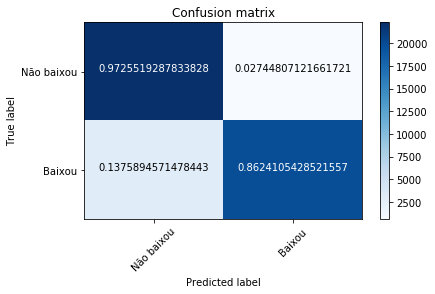

In [60]:
roc_usample_counts = clf_eval(rf, X_cv, Y_cv, normalize=True)

## 2. Using only data from last day to train

In [112]:
train_columns = ['ip', 'app', 'device', 'os', 'channel', 'hours', 'days', 'seconds', 'is_attributed']

# Importing data
start_time = time.time()
df_train_30m = pd.read_csv(path + '10_train_timed.csv', dtype=dtypes, usecols=train_columns)
print('Load df_train_30m with {} seconds'.format(round(time.time() - start_time, 3)))

Load df_train_30m with 18.537 seconds


In [113]:
# Load testing df
start_time = time.time()
df_test = pd.read_csv(path + 'test_timed.csv', dtype=dtypes)
print('Load df_test with {} seconds'.format(round(time.time() - start_time, 3)))



Load df_test with 19.108 seconds


In [107]:
df_train_30m.days.unique()

array([6, 7, 8, 9])

In [114]:
#Only last day
df_train_30m = df_train_30m[df_train_30m.days == 9]
train_record_index = df_train_30m.shape[0]

#Extracting learning data
Learning_Y = df_train_30m['is_attributed']
print('Training target correctly extracted.')

#drop zone
df_test = df_test.drop(['click_id', 'days', 'minutes'], axis=1)
df_train_30m = df_train_30m.drop(['is_attributed', 'days'], axis=1)
gc.collect();



Training target correctly extracted.


In [115]:
df_test.head()

,ip,app,device,os,channel,hours,seconds
0,5744,9,1,3,107,4,0
1,119901,9,1,3,466,4,0
2,72287,21,1,19,128,4,0
3,78477,15,1,13,111,4,0
4,123080,12,1,13,328,4,0


In [116]:
df_train_30m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5302464 entries, 13187924 to 18490387
Data columns (total 7 columns):
ip         uint32
app        uint16
device     uint16
os         uint16
channel    uint16
hours      int64
seconds    int64
dtypes: int64(2), uint16(4), uint32(1)
memory usage: 182.0 MB


In [117]:
df_merge = pd.concat([df_train_30m, df_test])
del df_train_30m, df_test
gc.collect();
print('Data was correctly merged')

Data was correctly merged


In [118]:
# Count all features except device for both train and test df 
start_time = time.time()
columns = df_merge.columns
columns = [i for i in columns if i != 'device']

for col in columns:
    df_count = df_merge[col].value_counts().reset_index(name=col+'_count')
    df_count.columns = [col, col+'_count']
#print('Starting to merge with main dataset...')
    df_merge = df_merge.merge(df_count, on=col, how='left', sort=False)
    df_merge[col+'_count'] = df_merge[col+'_count'].astype('uint16')
#print('Merging operation completed.')
    del df_count
    
print('Loaded counts for all features with {} seconds'.format(round(time.time() - start_time, 3)))

Loaded counts for all features with 39.865 seconds


In [119]:
df_merge = df_merge.drop(['hours_count', 'seconds_count'], axis=1)
gc.collect();

df_train = df_merge[:train_record_index]
df_test = df_merge[train_record_index:]

del df_merge
gc.collect();

In [120]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5302464 entries, 0 to 5302463
Data columns (total 11 columns):
ip               uint32
app              uint16
device           uint16
os               uint16
channel          uint16
hours            int64
seconds          int64
ip_count         uint16
app_count        uint16
os_count         uint16
channel_count    uint16
dtypes: int64(2), uint16(8), uint32(1)
memory usage: 222.5 MB


In [121]:
Learning_Y.describe()

count    5.302464e+06
mean     2.548061e-03
std      5.041397e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: is_attributed, dtype: float64

### 2.1 Baseline

In [122]:
# Separating training data in train and cross-validation
train_idx, test_idx = model_selection.StratifiedKFold(n_splits=2).split(df_train, Learning_Y)

X_train = df_train.iloc[train_idx[:1]]
Y_train = Learning_Y.iloc[train_idx[:1]]

X_cv = df_train.iloc[test_idx[:1]]
Y_cv = Learning_Y.iloc[test_idx[:1]]

In [123]:
# Selecting the features
param = X_train.columns
param = [i for i in param if i != 'ip' and i != 'app_count' and i != 'os_count' and i != 'channel_count']
X = X_train[param]
XX_cv = X_cv[param]

In [125]:
# Start of Random Forest Implementation

print('Starting to fit Random Forest Model... The machine is learning...')
start_time = time.time()
rf = RandomForestClassifier(n_estimators=13, max_depth=13, verbose=0, n_jobs = -1)
rf = rf.fit(X, Y_train)
print('The machine has learned.')
print('RandomForest has fitted df_train_30m with {} seconds'.format(round(time.time() - start_time), 3))

Starting to fit Random Forest Model... The machine is learning...
The machine has learned.
RandomForest has fitted df_train_30m with 37 seconds


### 2.1.1 Evaluating

Classification Report
             precision    recall  f1-score   support

 Não baixou       1.00      1.00      1.00   2644477
     Baixou       0.76      0.29      0.42      6756

avg / total       1.00      1.00      1.00   2651233

ROC Score: 0.6439767240226116
Accuracy Score: 0.9979518963440784
Average Precision Score: 0.2203117606680864
f1 Score: 0.41763191763191765
Normalized confusion matrix
[[9.99765171e-01 2.34829042e-04]
 [7.11811723e-01 2.88188277e-01]]


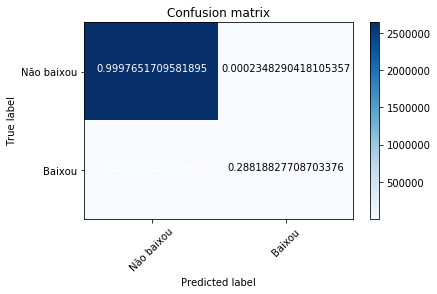

In [126]:
roc_lastday = clf_eval(rf, XX_cv, Y_cv, normalize=True)

## 1.3 Undersampling

In [127]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X_resampled, Y_resampled, idx_resampled = rus.fit_sample(df_train, Learning_Y)

X_resampled = pd.DataFrame(X_resampled, columns=df_train.columns)
Y_resampled = pd.DataFrame(Y_resampled, columns=['is_attributed'])

train_idx, test_idx = model_selection.StratifiedKFold(n_splits=2).split(X_resampled, Y_resampled)

X_train = X_resampled.iloc[train_idx[:1]]
Y_train = Y_resampled.iloc[train_idx[:1]]

X_cv = X_resampled.iloc[test_idx[:1]]
Y_cv = Y_resampled.iloc[test_idx[:1]]

In [128]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13510 entries, 6756 to 27021
Data columns (total 11 columns):
ip               13510 non-null int64
app              13510 non-null int64
device           13510 non-null int64
os               13510 non-null int64
channel          13510 non-null int64
hours            13510 non-null int64
seconds          13510 non-null int64
ip_count         13510 non-null int64
app_count        13510 non-null int64
os_count         13510 non-null int64
channel_count    13510 non-null int64
dtypes: int64(11)
memory usage: 1.2 MB


Note que mesmo após o undersampling ficamos com uma boa quantidade de dados, graças ao tamanho da base de dados original. Após feito o undersampling, vamos tentar várias features diferentes

### 1.3.1 Fitting (baseline)

In [129]:
# Selecting the features (baseline)
param = X_train.columns
param = [i for i in param if i != 'ip' and i != 'app_count' and i != 'os_count' and i != 'channel_count']
X = X_train[param]
XX_cv = X_cv[param]

In [130]:
# Start of Random Forest Implementation

print('Starting to fit Random Forest Model... The machine is learning...')
start_time = time.time()
rf = RandomForestClassifier(n_estimators=13, max_depth=13, verbose=0, n_jobs = -1)
rf = rf.fit(X, Y_train['is_attributed'])
print('The machine has learned.')
print('RandomForest has fitted df_train_30m with {} seconds'.format(round(time.time() - start_time), 3))

Starting to fit Random Forest Model... The machine is learning...
The machine has learned.
RandomForest has fitted df_train_30m with 0 seconds


#### 1.3.1 Evaluating (baseline)

Classification Report
             precision    recall  f1-score   support

 Não baixou       0.51      0.97      0.67      6756
     Baixou       0.71      0.08      0.14      6756

avg / total       0.61      0.52      0.41     13512

ROC Score: 0.5232386027235051
Accuracy Score: 0.5232386027235051
Average Precision Score: 0.5164199074506871
f1 Score: 0.1428951569984034
Normalized confusion matrix
[[0.9669923 0.0330077]
 [0.9205151 0.0794849]]


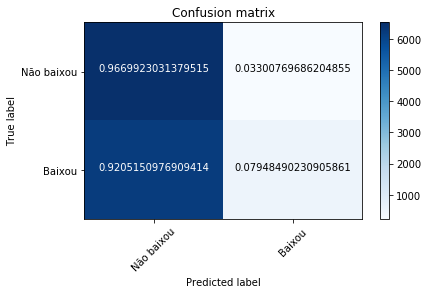

In [132]:
roc_usample_lastday_bl = clf_eval(rf, XX_cv, Y_cv, normalize=True)

### 1.3.2 Fitting (counts)

In [133]:
# Selecting the features
param = X_train.columns
param = [i for i in param if i != 'ip' and i != 'app' and i != 'os' and i != 'channel' and i != 'device']
X = X_train[param]
XX_cv = X_cv[param]

In [134]:
# Start of Random Forest Implementation

print('Starting to fit Random Forest Model... The machine is learning...')
start_time = time.time()
rf = RandomForestClassifier(n_estimators=13, max_depth=13, verbose=0, n_jobs = -1)
rf = rf.fit(X, Y_train['is_attributed'])
print('The machine has learned.')
print('RandomForest has fitted df_train_30m with {} seconds'.format(round(time.time() - start_time), 3))

Starting to fit Random Forest Model... The machine is learning...
The machine has learned.
RandomForest has fitted df_train_30m with 0 seconds


#### 1.3.2 Evaluating (counts)

Classification Report
             precision    recall  f1-score   support

 Não baixou       0.51      0.95      0.66      6756
     Baixou       0.61      0.08      0.14      6756

avg / total       0.56      0.51      0.40     13512

ROC Score: 0.5144316163410302
Accuracy Score: 0.5144316163410302
Average Precision Score: 0.5087914885660922
f1 Score: 0.14224081579291412
Normalized confusion matrix
[[0.94834221 0.05165779]
 [0.91947898 0.08052102]]


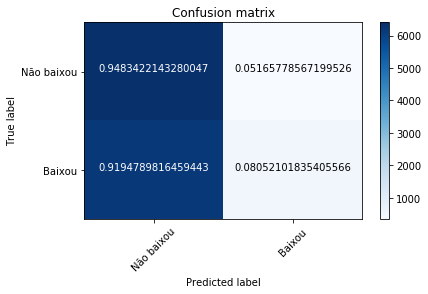

In [135]:
roc_usample_lastday_counts = clf_eval(rf, XX_cv, Y_cv, normalize=True)

### 1.3.3 Fitting (everything)

In [136]:
# Start of Random Forest Implementation

print('Starting to fit Random Forest Model... The machine is learning...')
start_time = time.time()
rf = RandomForestClassifier(n_estimators=13, max_depth=13, verbose=0, n_jobs = -1)
rf = rf.fit(X_train, Y_train['is_attributed'])
print('The machine has learned.')
print('RandomForest has fitted df_train_30m with {} seconds'.format(round(time.time() - start_time), 3))

Starting to fit Random Forest Model... The machine is learning...
The machine has learned.
RandomForest has fitted df_train_30m with 0 seconds


#### 1.3.3 Evaluating (everything)

Classification Report
             precision    recall  f1-score   support

 Não baixou       0.51      0.96      0.67      6756
     Baixou       0.70      0.09      0.16      6756

avg / total       0.61      0.53      0.41     13512

ROC Score: 0.5250148016577856
Accuracy Score: 0.5250148016577857
Average Precision Score: 0.5175162888385679
f1 Score: 0.15552631578947368
Normalized confusion matrix
[[0.96255181 0.03744819]
 [0.9125222  0.0874778 ]]


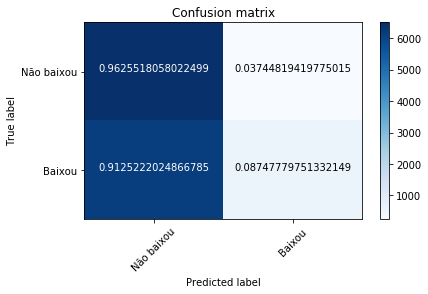

In [137]:
roc_usample_lastday_every = clf_eval(rf, X_cv, Y_cv, normalize=True)

# Sending prediction

In [18]:
#First you have to run the model you want
# Predict
print('Starting prediction phase...')
start_time = time.time()
predictions = rf.predict_proba(df_test[param])
print('Prediction done. Elapsed time: {} seconds'.format(round(time.time() - start_time, 3)))

Starting prediction phase...
Prediction done. Elapsed time: 16.189 seconds


In [19]:
# Creating the submission dataset

df_submit['is_attributed'] = predictions[:,1]
print('Submission dataset created.')
df_submit.head()

Submission dataset created.


In [21]:
# Preparing submssion
df_submit.to_csv('RF_undersample.csv', index=False)
print('Submission dataset saved correctly.')

df_submit.describe()

Submission dataset saved correctly.


,click_id,is_attributed
count,1.879047e+07,1.879047e+07
mean,9.395234e+06,1.544636e-01
std,5.424341e+06,1.701872e-01
min,0.000000e+00,0.000000e+00
25%,4.697617e+06,6.018821e-02
50%,9.395234e+06,9.477477e-02
75%,1.409285e+07,1.709969e-01
max,1.879047e+07,1.000000e+00
